In [243]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [244]:
df=pd.read_csv('train.csv')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [245]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Проверка на выбросы и их обработка

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [246]:
df_obj_features = df.select_dtypes(include='object')
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [247]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [248]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Обработка выбросов

In [249]:
df[df['Square'] <= 10]
# проверяем сколько площадей меньше 10 кв м

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006


In [250]:
df.loc[df['Square']<=10, 'Square']=df['Square'].median()

In [251]:
df[df['KitchenSquare']>=df['Square']]
# в квартире может и не быть кухни в случае если это апартаменты, но размер кухни не может быть больше чем площадь квартиры

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


In [252]:
df.loc[df['KitchenSquare']>=df['Square'], 'KitchenSquare']=df['KitchenSquare'].median()

In [254]:
df[df['LifeSquare'] >= df['Square']]
# проверяем сколько жилой площади больше чем общей площадиб в идеале смотреть конечно минус кухня но там выходит 
#800 строк не будем так сильно придираться к данным 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2.0,59.015896,59.439082,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
9889,12918,23,2.0,51.440463,53.134243,51.0,3,17.0,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.012510
9895,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047
9902,14001,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161


In [255]:
df.loc[df['LifeSquare']>= df['Square'], 'LifeSquare']= df['Square']

In [256]:
df[df['HouseFloor']==0]
#  в доме не может быть 0 этажей 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
44,10521,38,3.0,104.211396,104.211396,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.0,46.072913,46.072913,0.0,4,0.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.094034
9769,9384,59,3.0,98.607328,NaN,0.0,14,0.0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.257473
9878,11441,62,2.0,71.985335,71.985335,0.0,5,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,158841.624543
9908,3171,62,1.0,35.873961,NaN,0.0,25,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,134379.130962


In [257]:
df.loc[df['HouseFloor']==0, 'HouseFloor']=df['HouseFloor'].median()

In [258]:
df.loc[df['HouseFloor']<df['Floor'], 'HouseFloor']=df['Floor']
# квартира не может находится на 10 этаже если всего в доме меньше 10 этажей

In [259]:
df.loc[df['Rooms']==0, 'Rooms']=df['Rooms'].median()

In [260]:
df[df['Social_2']>=18000]
# проверяем выброс ли это или нет - не выброс

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
12,6452,13,2.0,54.522805,31.759753,1.0,8,12.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.372609
198,10736,13,3.0,80.030330,47.801599,10.0,16,17.0,1992,0.090799,B,B,74,19083,2,NaN,5,15,B,311528.100863
278,8179,13,2.0,55.232957,32.530879,8.0,11,17.0,1998,0.090799,B,B,74,19083,2,NaN,5,15,B,237568.671581
325,10550,12,3.0,81.734269,48.328522,10.0,8,14.0,1995,0.090799,B,B,74,19083,2,NaN,5,15,B,289429.685423
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9862,5785,13,1.0,42.053535,24.087096,10.0,11,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,179540.436574
9872,14136,12,1.0,43.711302,20.130061,8.0,18,18.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B,171513.507717
9935,6608,13,2.0,59.384809,36.738844,10.0,2,16.0,1982,0.090799,B,B,74,19083,2,NaN,5,15,B,85665.844941
9956,10715,13,1.0,38.475794,20.461320,10.0,17,22.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,178752.979404


In [261]:
df[df['Social_3']>=140]
# проверяем выброс ли это или нет - не выброс

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
271,7674,30,2.0,51.283020,51.283020,1.0,5,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,174735.177184
286,689,30,4.0,94.164934,60.322255,10.0,8,16.0,2005,0.000078,B,B,22,6398,141,1046.0,3,23,B,517817.162981
289,9320,30,3.0,76.265622,NaN,1.0,4,4.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,202260.788133
323,10144,30,2.0,62.180283,NaN,1.0,8,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,165895.486923
512,811,30,2.0,83.033107,NaN,1.0,2,12.0,2014,0.000078,B,B,22,6398,141,1046.0,3,23,B,200634.301894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9807,10088,30,1.0,37.191204,37.191204,1.0,17,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,147568.713397
9884,41,30,2.0,59.015896,59.015896,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
9923,16273,30,2.0,63.905356,NaN,1.0,6,25.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,189417.357268
9936,15173,30,2.0,62.341347,NaN,1.0,19,21.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,174256.265798


In [262]:
df[df['Healthcare_1']>=4000]
# проверяем выброс ли это или нет - не выброс

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
97,13671,84,3.0,63.728237,38.960935,6.0,9,9.0,1971,0.149666,B,B,22,4789,2,4087.0,4,1,B,291058.080899
179,11413,86,1.0,36.805826,17.986014,7.0,10,12.0,1974,0.161976,B,A,31,7010,5,4508.0,3,7,B,183891.147301
199,8478,86,2.0,59.967230,38.609430,8.0,10,25.0,2007,0.161976,B,A,31,7010,5,4508.0,3,7,B,161307.511982
207,3608,161,3.0,81.749640,51.415229,7.0,5,8.0,1964,0.000699,B,B,14,3369,24,4129.0,0,3,B,383231.960856
249,692,84,1.0,33.222505,22.661453,5.0,6,6.0,1961,0.149666,B,B,22,4789,2,4087.0,4,1,B,143121.975472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9780,3017,157,1.0,35.774843,19.200938,7.0,2,5.0,1961,0.000000,B,B,30,7538,87,4702.0,5,5,B,231360.118743
9784,1225,157,3.0,76.460332,49.979154,8.0,9,9.0,1960,0.000000,B,B,30,7538,87,4702.0,5,5,B,617749.118586
9837,5482,157,2.0,48.185943,33.156377,7.0,9,9.0,1963,0.000000,B,B,30,7538,87,4702.0,5,5,B,425837.404955
9881,5022,105,1.0,41.066385,19.878589,8.0,7,16.0,1981,0.042307,B,B,17,2810,9,4849.0,3,6,B,199636.932778


In [264]:
df[df['Shops_1']>=20]
# проверяем выброс ли это или нет - не выброс

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
271,7674,30,2.0,51.283020,51.283020,1.0,5,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,174735.177184
286,689,30,4.0,94.164934,60.322255,10.0,8,16.0,2005,0.000078,B,B,22,6398,141,1046.0,3,23,B,517817.162981
289,9320,30,3.0,76.265622,NaN,1.0,4,4.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,202260.788133
323,10144,30,2.0,62.180283,NaN,1.0,8,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,165895.486923
512,811,30,2.0,83.033107,NaN,1.0,2,12.0,2014,0.000078,B,B,22,6398,141,1046.0,3,23,B,200634.301894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9807,10088,30,1.0,37.191204,37.191204,1.0,17,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,147568.713397
9884,41,30,2.0,59.015896,59.015896,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
9923,16273,30,2.0,63.905356,NaN,1.0,6,25.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,189417.357268
9936,15173,30,2.0,62.341347,NaN,1.0,19,21.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,174256.265798


In [265]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.892100,56.374350,36.066661,5.861600,8.526700,13.567600,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.837811,20.979981,19.362562,5.070426,5.241148,5.996151,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,13.784865,0.370619,0.000000,1.000000,1.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.794392,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513580,32.772431,6.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.042275,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,638.163193,123.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обработка пропусков

In [266]:
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

In [267]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()

In [268]:
df.to_csv('train_prepared.csv', index=False, encoding='utf-8')

### Попробуем найти зависимости

In [269]:
df_num_features = df.select_dtypes(include='float64')

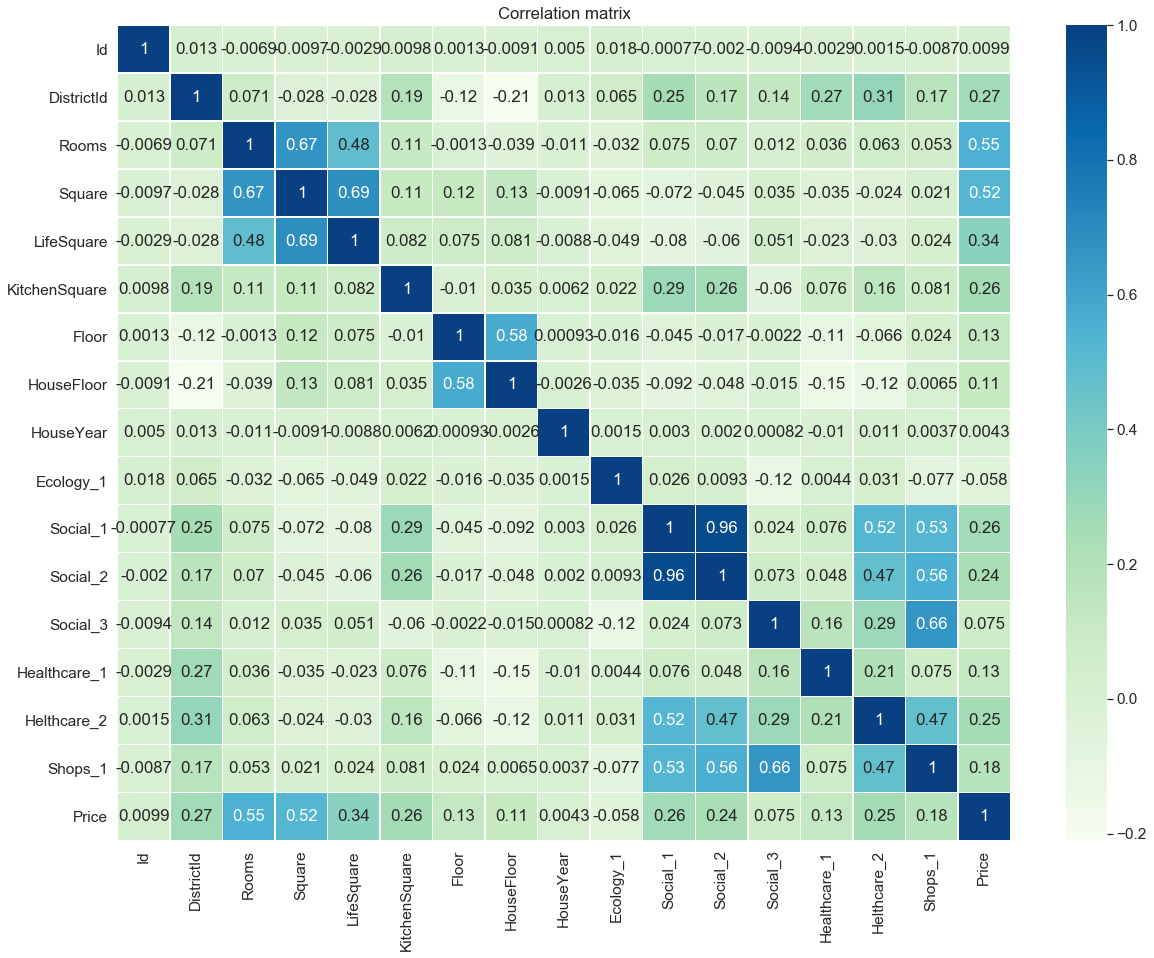

In [271]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()
# сильной зависимости с ценой не видно

### Разбиение выборки на тренировочную и тестовую

In [272]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [273]:
feature_names = ['DistrictId', 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
'Ecology_1',  'Social_1', 'Social_2', 'Social_3',
   'Healthcare_1', 'Helthcare_2' , 'Shops_1'            ]
target_name = 'Price'

In [274]:
feature_names_for_stand = df[feature_names].select_dtypes(include='float64').columns.tolist()

In [275]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,900.0,0,11,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


Стандартизация признаков

In [276]:
feature_names_for_stand = df[feature_names].select_dtypes(include='float64').columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1']

In [277]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [278]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [280]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,35,0.128794,-0.400058,-0.343701,0.027297,7,-0.761793,1969,-0.250529,33,7976,5,-0.169240,0,11,184966.930730
1,41,1.322440,0.443745,0.271290,0.421761,7,-0.761793,1978,-0.998053,46,10309,1,-1.053217,1,16,300009.450063
2,53,0.128794,-0.544661,-0.357915,-1.156095,8,-0.261447,1968,-0.581588,34,7759,0,-1.067950,1,3,220925.908524
3,58,0.128794,-0.144019,1.006601,0.618993,8,0.572463,1977,2.680470,23,5735,3,0.077202,0,5,175616.227217
4,99,-1.064851,-0.797236,-0.672254,0.224529,11,-0.261447,1976,-0.894969,35,5776,1,1.408526,2,4,150226.531644


In [281]:
df.to_csv('train_prepared_.csv', index=False, encoding='utf-8')

In [282]:
X = df[feature_names]
y = df[target_name]

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [284]:
from sklearn.linear_model import LinearRegression

Модель LinearRegression

In [285]:
lr = LinearRegression()

In [286]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [287]:
y_train_preds = lr.predict(X_train)

In [288]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

R2:	0.509
MAE:	44443.872
MSE:	4207660456.949


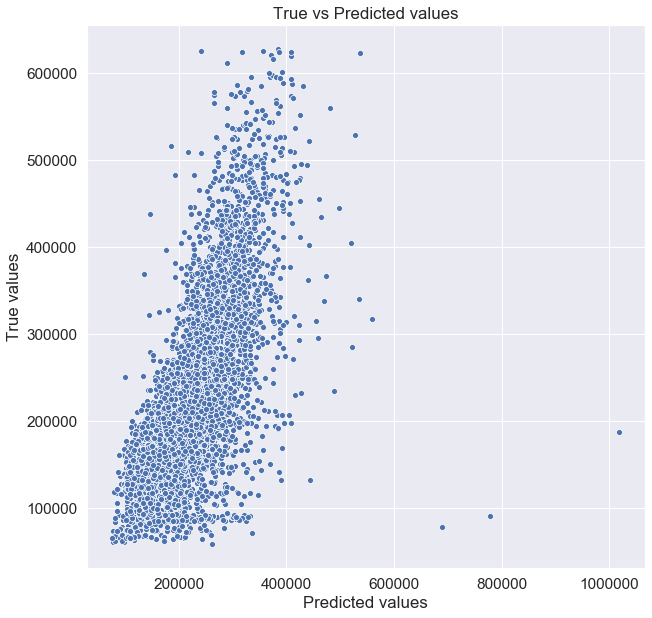

In [289]:
evaluate_preds(y_train, y_train_preds)

R2:	0.457
MAE:	45592.834
MSE:	4782663335.227


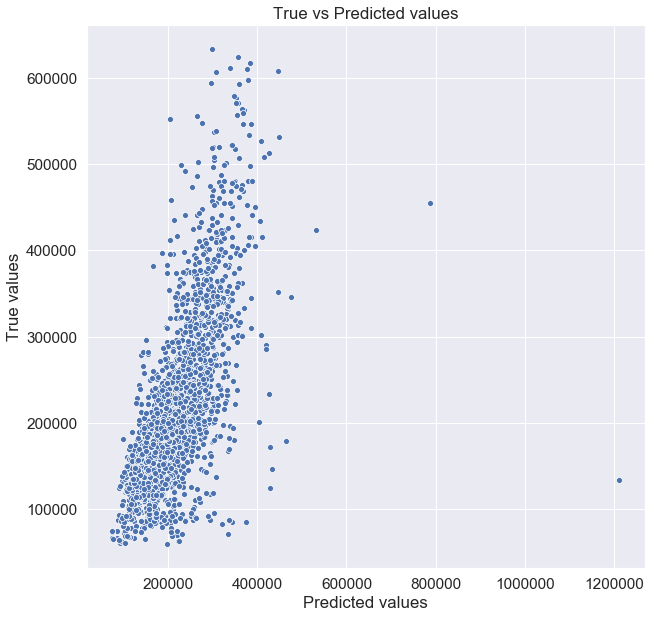

In [290]:
y_test_preds = lr.predict(X_test)
evaluate_preds(y_test, y_test_preds)

Результаты очень плохие

 Модель Random forest

In [291]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [292]:
rf_model = RandomForestRegressor()

In [293]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

R2:	0.962
MAE:	10549.835
MSE:	321967684.815


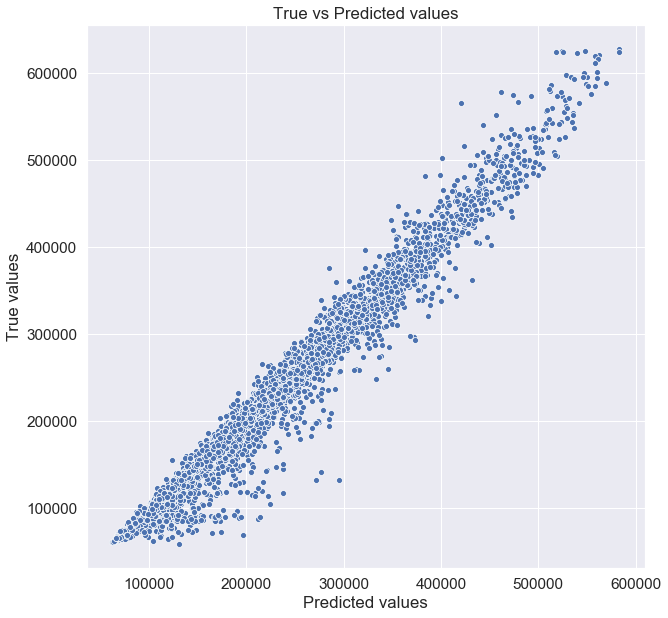

In [294]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.715
MAE:	29124.337
MSE:	2507210305.81


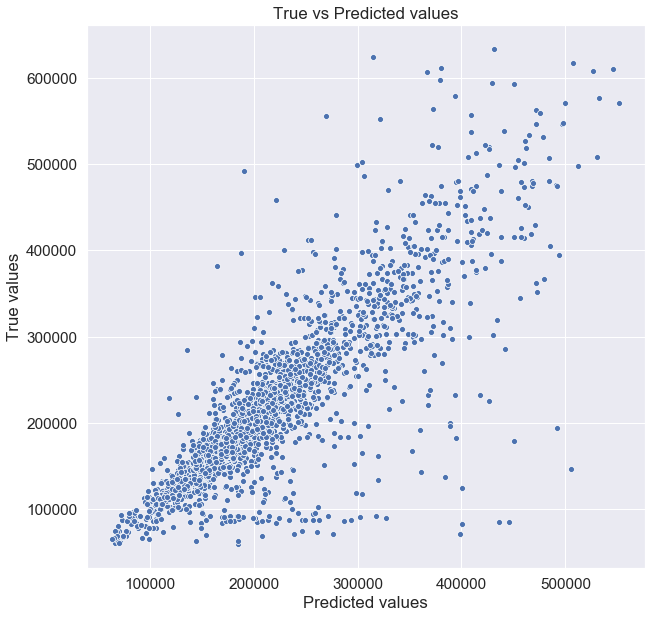

In [295]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

Результаты получше

Модель Gradient Boosting

In [296]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.77
MAE:	28644.25
MSE:	1969019915.188


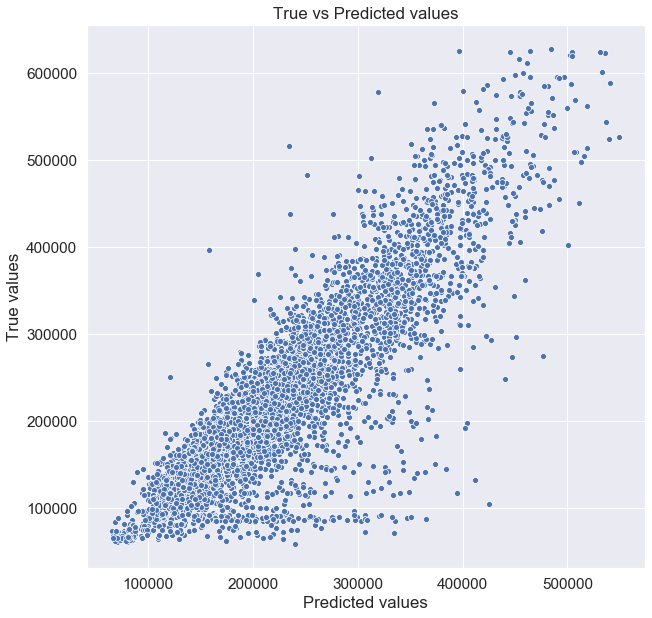

In [297]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.699
MAE:	31001.059
MSE:	2648316764.331


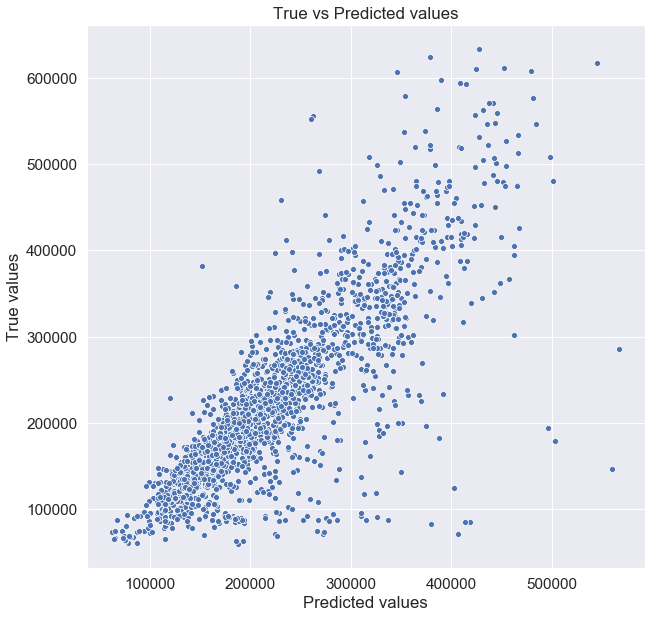

In [298]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

Результаты также еще низкие

Поэтому сделаем подбор гиперпараметров

In [299]:
gb_model = GradientBoostingRegressor(random_state=21)
gb_model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [300]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                             

In [301]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 100}

In [302]:
gs.best_score_

0.7439243636852949

In [303]:
final_model = GradientBoostingRegressor(n_estimators=100, max_depth=7, random_state=21)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.931
MAE:	16419.845
MSE:	588260888.506


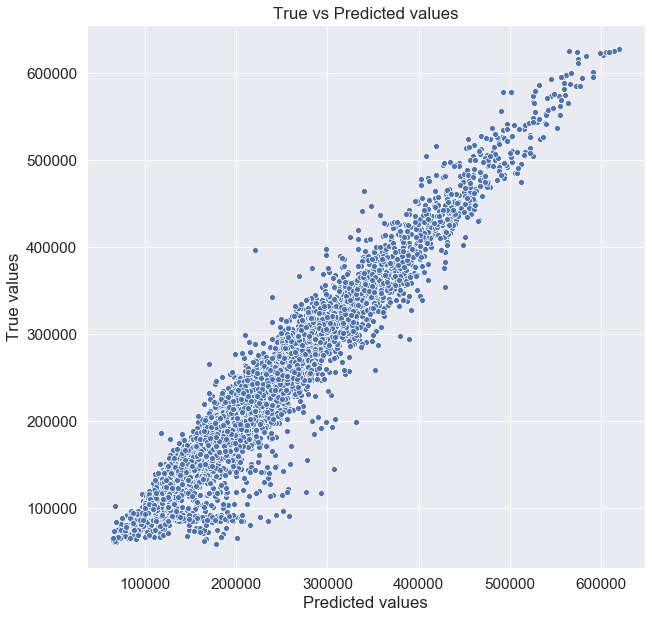

In [304]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.729
MAE:	27927.612
MSE:	2384385927.314


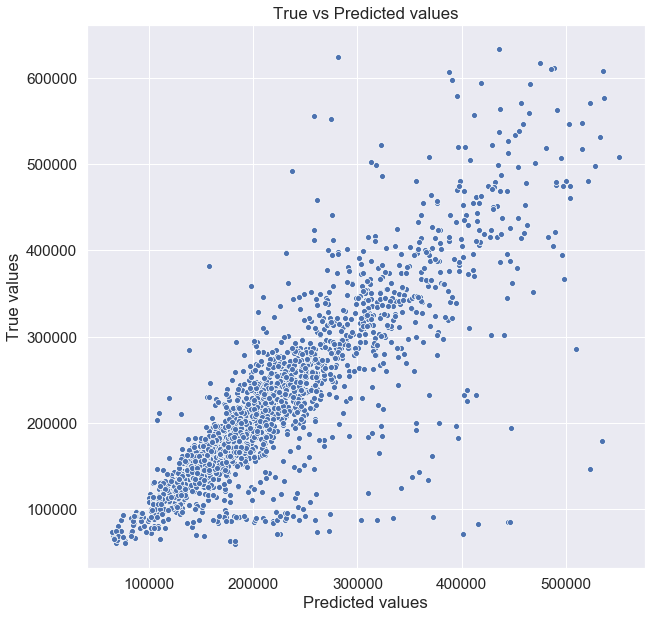

In [305]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

 Посмотрим чтобы понимать важность признаков

In [230]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.402324
10,Social_2,0.114843
9,Social_1,0.077662
1,Rooms,0.077177
11,Social_3,0.069222
0,DistrictId,0.048102
8,Ecology_1,0.042082
7,HouseYear,0.035636
12,Healthcare_1,0.024677
6,HouseFloor,0.023747


In [344]:
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl' 

In [345]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [346]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

Лучший результат показал градиентный бустинг с подобранными параметрами применим его на наших тестовых данных

In [319]:
df_test=pd.read_csv('test.csv')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [321]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [328]:
df_test.loc[df_test['Square']<=10, 'Square']=df_test['Square'].median()

In [329]:
df_test.loc[df_test['KitchenSquare']>=df_test['Square'], 'KitchenSquare']=df_test['KitchenSquare'].median()

In [330]:
df_test.loc[df['LifeSquare']>= df_test['Square'], 'LifeSquare']= df_test['Square']

In [331]:
df_test.loc[df_test['HouseFloor']==0, 'HouseFloor']=df_test['HouseFloor'].median()

In [332]:
df_test.loc[df_test['Rooms']==0, 'Rooms']=df_test['Rooms'].median()

In [333]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910800,56.528777,35.995277,5.822800,8.632000,12.915400,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.837725,18.974621,17.174611,4.633195,5.483228,6.468617,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,1.000000,13.305531,0.333490,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.940806,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.923101,32.892831,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.083374,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,168.729035,112.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [336]:
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

In [337]:
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()

In [338]:
df_test.to_csv('test_prepared.csv', index=False, encoding='utf-8')

In [348]:
scaler = StandardScaler()
stand_features_test = scaler.fit_transform(df_test[feature_names_for_stand])

In [349]:
df_test[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [350]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,0.128794,-0.400058,-0.343701,0.027297,6,-0.761793,1972,-0.250529,B,B,11,2748,1,-0.169240,0,0,B
1,15856,74,1.322440,0.443745,0.271290,0.421761,6,-0.761793,1977,-0.998053,B,B,6,1437,3,-1.053217,0,2,B
2,5480,190,0.128794,-0.544661,-0.357915,-1.156095,2,-0.261447,1909,-0.581588,B,B,30,7538,87,-1.067950,5,5,B
3,15664,47,0.128794,-0.144019,1.006601,0.618993,22,0.572463,2007,2.680470,B,B,23,4583,3,0.077202,3,3,B
4,14275,27,-1.064851,-0.797236,-0.672254,0.224529,17,-0.261447,2017,-0.894969,B,B,2,629,1,1.408526,0,0,A


In [357]:
X_test = df_test[feature_names]

In [358]:
final_model.predict(X_test)

array([173247.18716734, 227483.69623555, 372041.62491186, ...,
       249132.79187919, 179879.91245105, 153153.93597797])

In [359]:
check_test = pd.DataFrame({
    "id": df_test["Id"],
    "price": final_model.predict(X_test),
})

check_test.head(10)

,id,price
0,725,173247.187167
1,15856,227483.696236
2,5480,372041.624912
3,15664,200348.470547
4,14275,117259.543060
5,7633,317461.909218
6,13329,162611.016017
7,5502,348892.759528
8,4220,242668.316487
9,11538,126640.080430


In [360]:
check_test.to_csv('RBurganova_predictions.csv', index=False, encoding='utf-8')